In [27]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from scipy import signal

In [28]:
%reload_ext autoreload
%autoreload 2
import model_class

On aura besoin de cette fonction pour visualiser nos sorties sous forme de gif (on pourra mettre en .mp4 si besoin)

In [29]:
#Enregistre un gif de la hauteur d'eau dans le dossier ./maps
def animate(map,title):
    T = map.shape[0]

    fig, ax = plt.subplots()
    img = ax.imshow(map[0], cmap="viridis", origin="lower")
    fig.colorbar(img, ax=ax, label="Hauteur d'eau (m)")
    ax.set_title("Hauteur d'eau, t=0")
    ax.set_xlabel("Z1")
    ax.set_ylabel("Z2")
    def update(frame):
        img.set_data(map[frame])
        ax.set_title(title+f", t={frame/6:.2f}")
        return img

    anim = FuncAnimation(fig, update, frames=T, interval=200, blit=False)
    anim.save(f"./maps/hauteur_eau_"+title+".gif", writer="imagemagick")
    plt.close(fig)   # <-- Empêche l'affichage dans le notebook
    return None

# Utilisation de Processus Gaussien pour prédire une sortie scalaire à partir de données d'entrées fonctionnelles

On importe notre plan d'expérience créé au préalable dans le notebook **Doe Functionnal**

In [30]:
T=36                  # On regarde toutes les 10 minutes pendant 6 heures, ca nous fait donc 36 points
t=np.linspace(0,6,T)
dt = t[1] - t[0] 

best_plan_values = np.load("./data/best_plan_values.npy")
test_values = np.load("./data/test_values.npy")

print(best_plan_values.shape)
print(test_values.shape)

(200, 8, 36)
(2000, 8, 36)


In [31]:
def Campbell(x,z1,z2):
  return x[0]*np.exp(-(0.8*z1+0.2*z2-10*x[1])**2/(60*x[0]**2))+(x[1]+x[3])*np.exp((0.5*z1+0.5*z2)*x[0]/500)+x[4]*(x[2]-2)*np.exp(-(0.4*z1+0.6*z2-20*x[5])**2/(40*x[4]**2))+(x[5]+x[7])*np.exp((0.3*z1+0.7*z2)*x[6]/250)

On discrétise le domaine spatial.

In [32]:
n_grid = 64
D = n_grid**2
z1_vals=np.linspace(-90,90,n_grid)
z2_vals=np.linspace(-90,90,n_grid)

Z1,Z2=np.meshgrid(z1_vals,z2_vals)

On calcul à chaque pixel la hauteur d'eau pour une entrée à chaque pas de temps: 

In [34]:
def HE(e,Z1,Z2):
    vals = []
    for i in range(e.shape[1]):  
        vals.append(Campbell(e[:,i],Z1,Z2))  
    return np.array(vals)

In [35]:
n_test = 2000
n_train = 200

x_test = test_values  # shape = (2000,8,36)
y_test = np.zeros((n_test,T*n_grid*n_grid))   # shape = (2000, 36*4096)

x_train = best_plan_values # shape = (200,8,36)
y_train = np.zeros((n_train,T*n_grid*n_grid))   # shape = (200, 36*4096)

#On calcul les sorties y avec le Simulateur
for i in range(n_train):
    ytrain_i = HE(x_train[i], Z1, Z2)
    y_train[i,:] = ytrain_i.flatten()
for i in range(n_test):
    ytest_i = HE(x_test[i], Z1, Z2)
    y_test[i,:] = ytest_i.flatten()

On applique nos méthodes de prédiction:
- ACP classique
- B-spline et ACP
- Ondelettes et ACP


In [36]:
n_pc = 5  # On choisit arbitrairement le nombre de composantes principales (d'après la thèse, 5 semble un bon compromis)
theta = 3 # On choisit arbitrairement la valeur de theta 
sigma = 1 # et de sigma

Entrainement des modèles:

In [37]:
#ACP
ACP = model_class.ACP_classique(n_pc,[theta,sigma])
ACP.train(x_train,y_train,verbose=False)

#B-spline
nombre_noeuds_spatiaux=9
txy = np.concatenate((
    np.repeat(-90, 2),                                      
    np.linspace(-90, 90, nombre_noeuds_spatiaux - 2)[1:-1],# noeuds internes
    np.repeat(90, 2)
))
nombre_noeuds_temporels=6
tt = np.concatenate((
    np.repeat(0, 2),
    np.linspace(0, 36, nombre_noeuds_temporels - 2)[1:-1],
    np.repeat(36, 2)
))
print(txy.shape)
print(txy.shape)
print(tt.shape)
print("Le vecteur de noeuds utilisé pour la décompostion B-spline en spatial:",txy)
print("Le vecteur de noeuds utilisé pour la décompostion B-spline en temporel:",tt)

noeuds=[txy,txy,tt]
domaine=[z1_vals,z2_vals,t]

Bsplines = model_class.ACPF_Bsplines(n_pc,[theta,sigma],noeuds,domaine)
Bsplines.train(x_train,y_train,verbose=False)

#Ondelettes
p = 0.99999 #Il faut mettre un p quasiment égal à 1 pour obtenir un résultat satisfaisant
Ondelettes = model_class.ACPF_Ondelettes(n_pc,[theta,sigma],p,2)
Ondelettes.train(x_train,y_train,verbose=False)

--- Analyse en Composantes Principales ---
Variance expliquée par les 5 premières composantes : [0.75597463 0.08627852 0.02726587 0.0171792  0.01419371]
Variance globale expliquée : 0.9008919208529467
Taille du jeu d'entrainement transformé par ACP : (200, 5)

--- Entraînement du modèle GP pour la composante principale  1 ---
Modèle GP créé pour la composante principale  1 . Optimisation des hyperparamètres...
Optimisation terminée. Les hyperparamètres optimisés sont :
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value      │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪════════════╡
│ GPR.mean_function.c     │ Parameter │ Identity         │         │ True        │ (1,)    │ float64 │ [798.4458] │
├─────────────────────────┼───────────┼──────────────────┼────

Prédiction:

In [44]:
Y_test_reconstruct_ACP      = ACP.predict(x_test)
Y_test_reconstruct_Bsplines = Bsplines.predict(x_test)
Y_test_reconstruct_wavelet  = Ondelettes.predict(x_test)

Predict ACP
Prédiction effectuée pour la composante principale  1
Prédiction effectuée pour la composante principale  2
Prédiction effectuée pour la composante principale  3
Prédiction effectuée pour la composante principale  4
Prédiction effectuée pour la composante principale  5
Predict B-Splines
Predict ACP
Prédiction effectuée pour la composante principale  1
Prédiction effectuée pour la composante principale  2
Prédiction effectuée pour la composante principale  3
Prédiction effectuée pour la composante principale  4
Prédiction effectuée pour la composante principale  5
Predict Ondelettes
Predict ACP
Prédiction effectuée pour la composante principale  1
Prédiction effectuée pour la composante principale  2
Prédiction effectuée pour la composante principale  3
Prédiction effectuée pour la composante principale  4
Prédiction effectuée pour la composante principale  5


On redimensionne nos sorties pour revenir aux dimensions : (n_test,T,n_grid,n_grid)

In [39]:
y_test_reshaped  = y_test.reshape(2000, 36, 64, 64)

y_test_reconstruct_ACP_reshaped = Y_test_reconstruct_ACP.reshape(2000, 36, 64, 64)
Y_test_reconstruct_Bsplines_reshaped = Y_test_reconstruct_Bsplines.reshape(2000, 36, 64, 64)
Y_test_reconstruct_wavelet_reshaped = Y_test_reconstruct_wavelet.reshape(2000, 36, 64, 64)

print("shape des y:",y_test.shape)
print("shape des y_reshaped:",y_test_reshaped.shape)

shape des y: (2000, 147456)
shape des y_reshaped: (2000, 36, 64, 64)


On va chercher à calculer l'erreur. Cependant on ne peut plus calculer de carte RMSE comme avant, car on a maintenant la dépendance temporelle.  
On peut faire :
- Erreur L² globale
- RMSE globale
- RMSE par test
- RMSE par pas de temps
- RMSE par position sur la grille

In [40]:
def compute_errors(Y_true, Y_pred,verbose=False):
    diff = Y_pred - Y_true
    L2_global = np.linalg.norm(diff)
    RMSE_global = np.sqrt(np.mean(diff**2))
    RMSE_per_test = np.sqrt(np.mean(diff**2, axis=(1,2,3)))
    RMSE_per_time = np.sqrt(np.mean(diff**2, axis=(0,2,3)))
    RMSE_per_grid = np.sqrt(np.mean(diff**2, axis=(0,1)))
    if verbose:
        print("erreur L2",L2_global.shape)
        print("RMSE global",RMSE_global.shape)
        print("RMSE per test",RMSE_per_test.shape)
        print("RMSE per time",RMSE_per_time.shape)
        print("RMSE per grid",RMSE_per_grid.shape)
    return L2_global, RMSE_global, RMSE_per_test, RMSE_per_time, RMSE_per_grid

ACP_L2      , ACP_RMSE      , ACP_RMSE_test      , ACP_RMSE_time      , ACP_RMSE_grid       = compute_errors(y_test_reshaped, y_test_reconstruct_ACP_reshaped,verbose=True)
B_splines_L2, B_splines_RMSE, B_splines_RMSE_test, B_splines_RMSE_time, B_splines_RMSE_grid = compute_errors(y_test_reshaped, Y_test_reconstruct_Bsplines_reshaped)
wavelet_L2  , wavelet_RMSE  , wavelet_RMSE_test  , wavelet_RMSE_time  , wavelet_RMSE_grid   = compute_errors(y_test_reshaped, Y_test_reconstruct_wavelet_reshaped)


erreur L2 ()
RMSE global ()
RMSE per test (2000,)
RMSE per time (36,)
RMSE per grid (64, 64)


Erreur L2:
ACP: 20281.0366095943   B-splines: 49561.48851384146   Ondelettes: 20281.20075870017

RMSE:
ACP: 1.1809837633649682   B-splines: 2.8860119110162636   Ondelettes: 1.1809933219211968
On regarde la RMSE à chaque pas de temps


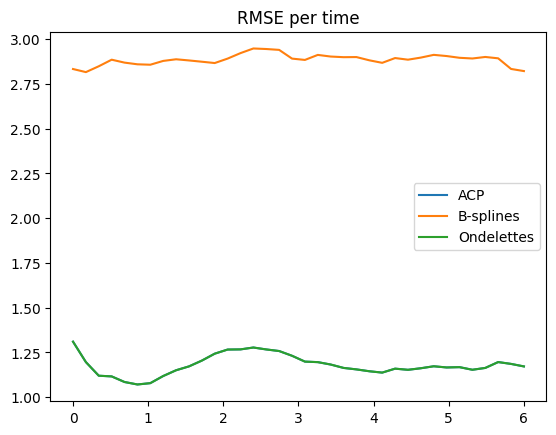

On regarde la RMSE à chaque pixel


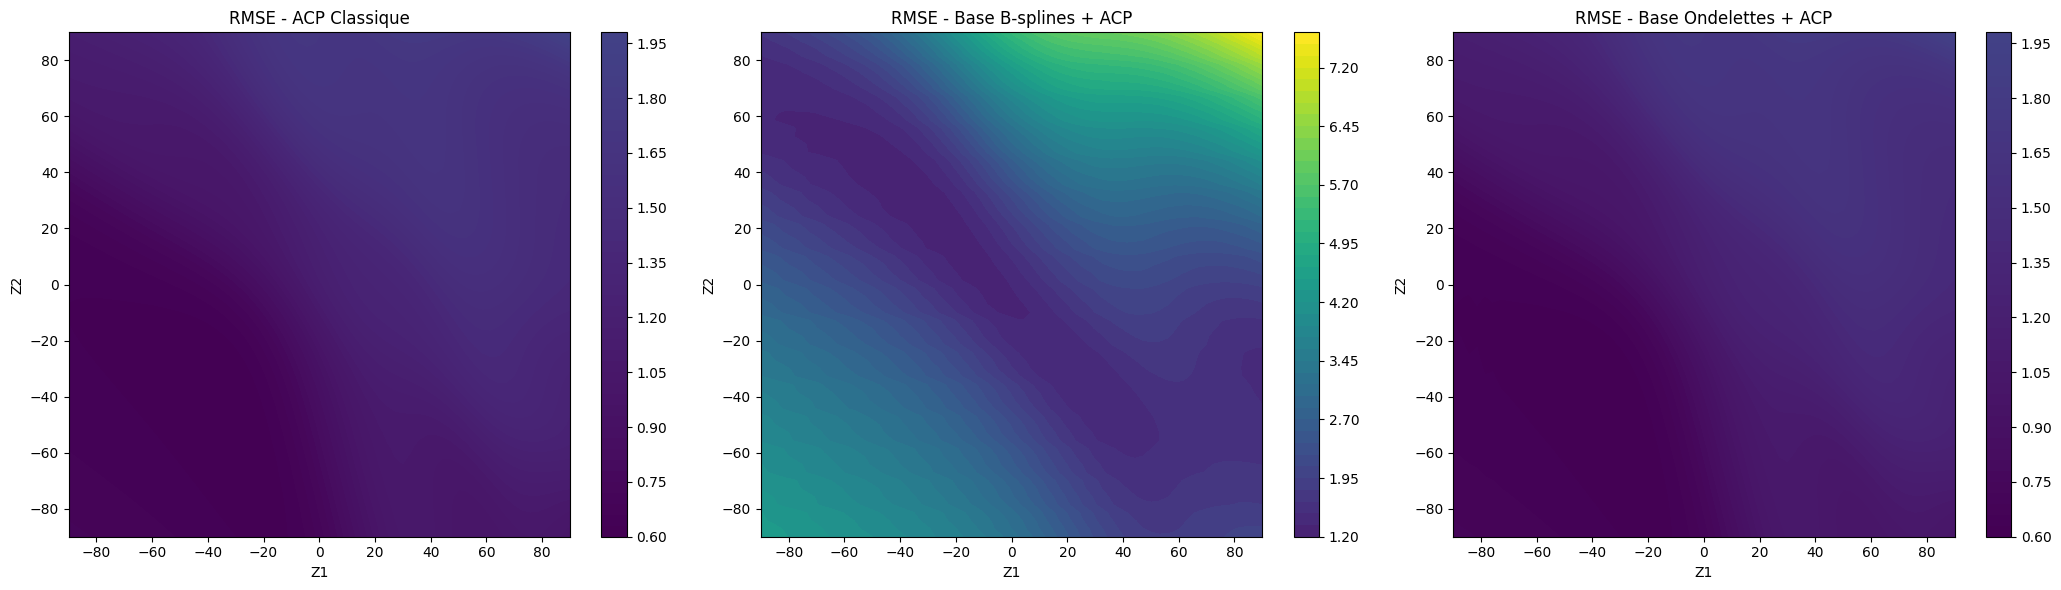

In [41]:
print("Erreur L2:")
print("ACP:",ACP_L2,"  B-splines:",B_splines_L2,"  Ondelettes:",wavelet_L2)

print("\nRMSE:")
print("ACP:",ACP_RMSE,"  B-splines:",B_splines_RMSE,"  Ondelettes:",wavelet_RMSE)

print("On regarde la RMSE à chaque pas de temps")
plt.plot(t,ACP_RMSE_time,label="ACP")
plt.plot(t,B_splines_RMSE_time,label="B-splines")
plt.plot(t,wavelet_RMSE_time,label="Ondelettes")
plt.title("RMSE per time")
plt.legend()
plt.show()

print("On regarde la RMSE à chaque pixel")
# --- Trouver les min/max communs pour la même échelle colorimétrique
vmin = min(ACP_RMSE_grid.min(), B_splines_RMSE_grid.min(), wavelet_RMSE_grid.min())
vmax = max(ACP_RMSE_grid.max(), B_splines_RMSE_grid.max(), wavelet_RMSE_grid.max())

# --- Plot côte à côte
plt.figure(figsize=(21, 6))

# ACP classique
plt.subplot(1, 3, 1)
contour1 = plt.contourf(Z1, Z2, ACP_RMSE_grid, levels=50,vmin = vmin, vmax=vmax)
plt.colorbar(contour1)
plt.title("RMSE - ACP Classique")
plt.xlabel("Z1")
plt.ylabel("Z2")

# ACP + B-splines
plt.subplot(1, 3, 2)
contour2 = plt.contourf(Z1, Z2, B_splines_RMSE_grid, levels=50,vmin = vmin, vmax=vmax)
plt.colorbar(contour2)
plt.title("RMSE - Base B-splines + ACP")
plt.xlabel("Z1")
plt.ylabel("Z2")

# ACP + Ondelettes
plt.subplot(1, 3, 3)
contour3 = plt.contourf(Z1, Z2, wavelet_RMSE_grid, levels=50,vmin = vmin, vmax=vmax)
plt.colorbar(contour3)
plt.title("RMSE - Base Ondelettes + ACP")
plt.xlabel("Z1")
plt.ylabel("Z2")

plt.tight_layout()
plt.show()

La méthode B-splines n'est plus adaptée. Il faut la modifié car maintenant on est en dimension 3 !

On peut regarder ce que ca donne pour une entrée i avec la méthode ACP.  
On va créer dans le dossier **./maps** 3 gifs : 
- La vraie sortie : *hauteur_eau_relle_i.gif*
- La sortie reconstruite : *hauteur_eau_reconstruite_i.gif*
- La différence : *hauteur_eau_erreur_i.gif*

In [43]:
i = np.random.choice(2000) # On regarde une entrée au hasard

vraie_sortie        = y_test_reshaped[i]
sortie_reconstruite = y_test_reconstruct_ACP_reshaped[i]
erreur = abs(vraie_sortie-sortie_reconstruite)

animate(vraie_sortie,f"réelle_{i}")
animate(sortie_reconstruite,f"reconstruite_{i}")
animate(erreur,f"erreur_{i}")